In [146]:
#importar bibliotecas
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score , f1_score, precision_score, recall_score
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import  GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
%matplotlib inline

In [147]:
#lendo o arquivo BRAS.csv
#O arquivo utilizado foi baixado do site www.football-data.co.uk, que agrega informações de diversos campeonatos
#ao redor do mundo.

data=pd.read_csv('BRA.csv',delimiter=',')

#cria um data frame dimensão somente com os nome dos times
equipes = pd.DataFrame(data, columns=['Home'])

#ordenando os valores
equipes.sort_values('Home', inplace = True)
 
#elimina todos os valores duplicados
equipes = equipes.drop_duplicates(subset='Home', keep='first')

#cria coluna para identificação dos times
equipes.insert(0,'id_time',equipes.index,allow_duplicates=False)

#verifica o resultado do data frame
display(equipes.head())

#Verificando as 5 primeiras linhas do arquivo a ser utilizado
display(data.head())

display('===========')

#Notes for football data

#Country = país do campeonato
#League = nome da liga
#game_id = id do jogo
#Season = temporada
#date = data do jogo
#Time = hora do jogo
#Home = Time da casa
#home_id = id do time da casa
#Away = time visitante
#Away_id =  id do time visitante
#HG = Gols do time da casa
#AG = Gols do time visitante
#Res = Resultado do jogo (D=Draw, H=Home win, A=Away win)
#PH = probablidade vitória time da casa provida pela Pinacle (casa de aposta inglesa)
#PD = probablidade empate provida pela Pinacle (casa de aposta inglesa)
#PA = probablidade vitória time visitante provida pela Pinacle (casa de aposta inglesa)
#MaxH = probablidade vitória time da casa provida pela OddsPortal (casa de aposta inglesa)
#MaxD = probablidade empate provida pela OddsPortal (casa de aposta inglesa)
#MaxA = probablidade vitória time visitante provida pela OddsPortal (casa de aposta ingles
#AvgH = probablidade média de vitória em casa provida pela OddsPortal (casa de aposta inglesa)
#AvgD = probablidade média de empate provida pela OddsPortal (casa de aposta inglesa)
#AvgA = probablidade média de vitória pelo time visitante provida pela OddsPortal (casa de aposta inglesa)

,id_time,Home
3730,3730,America MG
3707,3707,Athletico-PR
3262,3262,Atletico GO
3059,3059,Atletico-MG
968,968,Atletico-PR


,Country,League,Season,Date,Time,Home,Away,HG,AG,Res,PH,PD,PA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA
0,Brazil,Serie A,2012,19/05/2012,22:30,Palmeiras,Portuguesa,1.0,1.0,D,1.75,3.86,5.25,1.76,3.87,5.31,1.69,3.50,4.90
1,Brazil,Serie A,2012,19/05/2012,22:30,Sport Recife,Flamengo RJ,1.0,1.0,D,2.83,3.39,2.68,2.83,3.42,2.70,2.59,3.23,2.58
2,Brazil,Serie A,2012,20/05/2012,01:00,Figueirense,Nautico,2.0,1.0,H,1.60,4.04,6.72,1.67,4.05,7.22,1.59,3.67,5.64
3,Brazil,Serie A,2012,20/05/2012,20:00,Botafogo RJ,Sao Paulo,4.0,2.0,H,2.49,3.35,3.15,2.49,3.39,3.15,2.35,3.26,2.84
4,Brazil,Serie A,2012,20/05/2012,20:00,Corinthians,Fluminense,0.0,1.0,A,1.96,3.53,4.41,1.96,3.53,4.41,1.89,3.33,3.89


'==========='

In [148]:
#Explorando os dados
#Base de dados de dos campeonatos de 2012 a 2022

#substituindo os valores string H, A ou D da coluna Res para valores do tipo
#numéricos onde H = 1 (vitória time da casa)
# A = 2 (vitória time visitante)
# D = 0 (empate)

data['Res'] = data['Res'].map({'H':1,
                               'A':2,
                               'D':0},
                              na_action=0)


matches = data.shape[0]

features = data.shape[1] -1 #Retirando a coluna Resultado

#inseri coluna para identificar os jogos
#o id_jogo será igual ao índice da linha do data frame
data.insert(5,'id_jogo',data.index,allow_duplicates=False)

data = data.join(equipes.set_index('Home'), on='Home', how='inner')

data.rename(columns = {'id_time':'home_id'}, inplace = True)

data = data.join(equipes.set_index('Home'), on='Away', how='inner')

data.rename(columns = {'id_time':'away_id'}, inplace = True)

display(data.head())

# data = data['Res'].fillna(0)

# data = data.Res.astype('int64')

home_win = len(data[data.Res==1])
away_win = len(data[data.Res==2])
draw = len(data[data.Res==0])
val=[home_win,away_win,draw]

win_rate = ((home_win)/(matches)) *100

print ('Total de jogos: ', matches)
print ('Total de colunas: ', features)
print ('Total de jogos ganhos em casa: ', home_win)
print ('Total de jogos ganhos pelo visitante: ', away_win)
print ('Total de jogos empatados: ', draw)
print ('Percentual de jogos ganhos em casa: {:.2f}%'.format( win_rate ))

#Podemos notar que o "fator casa" é importante , sendo que em quase 50% do jogos são ganhos pelo time da casa.

,Country,League,Season,Date,Time,id_jogo,Home,Away,HG,AG,...,PD,PA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA,home_id,away_id
0,Brazil,Serie A,2012,19/05/2012,22:30,0,Palmeiras,Portuguesa,1.0,1.0,...,3.86,5.25,1.76,3.87,5.31,1.69,3.50,4.90,3028,729
88,Brazil,Serie A,2012,15/07/2012,22:30,88,Sport Recife,Portuguesa,2.0,1.0,...,3.45,3.56,2.25,3.70,3.80,2.06,3.32,3.43,936,729
327,Brazil,Serie A,2012,27/10/2012,21:30,327,Figueirense,Portuguesa,0.0,0.0,...,3.62,2.99,2.41,3.80,3.20,2.26,3.31,2.96,1606,729
341,Brazil,Serie A,2012,10/11/2012,21:30,341,Botafogo RJ,Portuguesa,3.0,0.0,...,3.76,5.04,1.78,4.00,5.60,1.68,3.57,4.84,1689,729
712,Brazil,Serie A,2013,13/11/2013,23:00,712,Botafogo RJ,Portuguesa,0.0,0.0,...,4.21,6.34,1.65,4.33,6.50,1.58,3.86,5.50,1689,729


Total de jogos:  3910
Total de colunas:  18
Total de jogos ganhos em casa:  1907
Total de jogos ganhos pelo visitante:  942
Total de jogos empatados:  1060
Percentual de jogos ganhos em casa: 48.77%


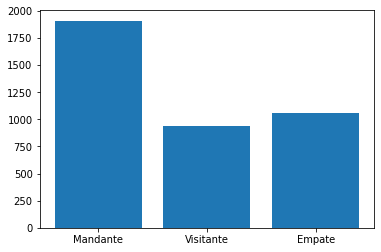

In [149]:
#Visualizando os dados

x = np.arange(3)
plt.bar(x, val)
plt.xticks(x, ('Mandante', 'Visitante', 'Empate'))
plt.show()

In [150]:
#Preparando os dados
# data = data.reset_index()

#Deixar somente as variáveis numericas 
#num_data = data.drop(['Country','League','Season','Date','Time','Home','Away'],1)
data = data.sort_values(by=['id_jogo'], ascending=True)
print (data)

num_data = data.drop(['Country','League','Season','Date','Time', 'Home', 'Away'],1)

display(num_data.head())

     Country   League  Season        Date   Time  id_jogo          Home  \
0     Brazil  Serie A    2012  19/05/2012  22:30        0     Palmeiras   
1     Brazil  Serie A    2012  19/05/2012  22:30        1  Sport Recife   
2     Brazil  Serie A    2012  20/05/2012  01:00        2   Figueirense   
3     Brazil  Serie A    2012  20/05/2012  20:00        3   Botafogo RJ   
4     Brazil  Serie A    2012  20/05/2012  20:00        4   Corinthians   
...      ...      ...     ...         ...    ...      ...           ...   
3905  Brazil  Serie A    2022  12/06/2022  20:00     3905         Goias   
3906  Brazil  Serie A    2022  12/06/2022  20:00     3906     Sao Paulo   
3907  Brazil  Serie A    2022  12/06/2022  22:00     3907      Coritiba   
3908  Brazil  Serie A    2022  12/06/2022  23:00     3908     Fortaleza   
3909  Brazil  Serie A    2022  13/06/2022  23:00     3909   Botafogo RJ   

              Away   HG   AG  ...    PD    PA  MaxH  MaxD  MaxA  AvgH  AvgD  \
0       Portuguesa  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if __name__ == '__main__':


,id_jogo,HG,AG,Res,PH,PD,PA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA,home_id,away_id
0,0,1.0,1.0,0.0,1.75,3.86,5.25,1.76,3.87,5.31,1.69,3.50,4.90,3028,729
1,1,1.0,1.0,0.0,2.83,3.39,2.68,2.83,3.42,2.70,2.59,3.23,2.58,936,30
2,2,2.0,1.0,1.0,1.60,4.04,6.72,1.67,4.05,7.22,1.59,3.67,5.64,1606,604
3,3,4.0,2.0,1.0,2.49,3.35,3.15,2.49,3.39,3.15,2.35,3.26,2.84,1689,3418
4,4,0.0,1.0,2.0,1.96,3.53,4.41,1.96,3.53,4.41,1.89,3.33,3.89,1472,2146


In [153]:
#separa as features 
features = num_data.drop(['Res'],1)

#trata os valores NaN
data = data.fillna(0)
num_data = num_data.fillna(0)
print (data.isnull().any())
print('=========')
print (num_data.isnull().any())

#separa as labels
labels = num_data['Res']

print('Features')
print (features.head())

print ('=========')

print ('Labels')
print (labels.head())

Country    False
League     False
Season     False
Date       False
Time       False
id_jogo    False
Home       False
Away       False
HG         False
AG         False
Res        False
PH         False
PD         False
PA         False
MaxH       False
MaxD       False
MaxA       False
AvgH       False
AvgD       False
AvgA       False
home_id    False
away_id    False
dtype: bool
id_jogo    False
HG         False
AG         False
Res        False
PH         False
PD         False
PA         False
MaxH       False
MaxD       False
MaxA       False
AvgH       False
AvgD       False
AvgA       False
home_id    False
away_id    False
dtype: bool
Features
   id_jogo   HG   AG    PH    PD    PA  MaxH  MaxD  MaxA  AvgH  AvgD  AvgA  \
0        0  1.0  1.0  1.75  3.86  5.25  1.76  3.87  5.31  1.69  3.50  4.90   
1        1  1.0  1.0  2.83  3.39  2.68  2.83  3.42  2.70  2.59  3.23  2.58   
2        2  2.0  1.0  1.60  4.04  6.72  1.67  4.05  7.22  1.59  3.67  5.64   
3        3  4.0  2.0  2.49

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [154]:
#Escoolhendo as melhores features com Kbest

features_list = ('HG','AG','PH','PD','PA','MaxH','MaxD','MaxA','AvgH','AvgD','AvgA')

k_best_features = SelectKBest(k='all')
k_best_features.fit_transform(features, labels)
k_best_features_scores = k_best_features.scores_
raw_pairs = zip(features_list[1:], k_best_features_scores)
ordered_pairs = list(reversed(sorted(raw_pairs, key=lambda x: x[1])))

k_best_features_final = dict(ordered_pairs[:15])
best_features = k_best_features_final.keys()
print ('')
print ("Melhores features:")
print (k_best_features_final)


Melhores features:
{'PH': 1303.6427718643836, 'PD': 1245.1238457841273, 'PA': 157.3575247122717, 'AvgA': 153.0807026590068, 'MaxD': 140.57691482399093, 'AvgD': 139.10218934536894, 'MaxA': 138.32643195817448, 'AvgH': 70.34604335749522, 'MaxH': 68.21772011642172, 'AG': 1.9123378929847197}


In [155]:
#separa as features com base nas melhores features para treinamento
features = num_data.drop(['Res','id_jogo','home_id','away_id', 'AG','PD','PH'],1)

#separa as labels para treinamento
labels = num_data['Res']

print('Features')
print (features.head())

print ('=========')

print ('Labels')
print (labels.head())

Features
    HG    PA  MaxH  MaxD  MaxA  AvgH  AvgD  AvgA
0  1.0  5.25  1.76  3.87  5.31  1.69  3.50  4.90
1  1.0  2.68  2.83  3.42  2.70  2.59  3.23  2.58
2  2.0  6.72  1.67  4.05  7.22  1.59  3.67  5.64
3  4.0  3.15  2.49  3.39  3.15  2.35  3.26  2.84
4  0.0  4.41  1.96  3.53  4.41  1.89  3.33  3.89
Labels
0    0.0
1    0.0
2    1.0
3    1.0
4    2.0
Name: Res, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [156]:
# Normalizando os dados de entrada(features)

# Gerando o novo padrão
scaler = MinMaxScaler().fit(features)
features_scale = scaler.transform(features)

print ('Features: ',features_scale.shape)
print (features_scale)

Features:  (3910, 8)
[[0.16666667 0.17748479 0.02400573 ... 0.03235908 0.11913357 0.14746363]
 [0.16666667 0.09060176 0.06234325 ... 0.07933194 0.0866426  0.0562328 ]
 [0.33333333 0.22718053 0.02078108 ... 0.02713987 0.13959085 0.17656311]
 ...
 [0.         0.05679513 0.156933   ... 0.20720251 0.1456077  0.02084153]
 [0.         0.20554429 0.02078108 ... 0.02922756 0.15042118 0.17223751]
 [0.         0.16565247 0.02938015 ... 0.04018789 0.10469314 0.13291388]]


In [157]:
#Separa em treinamento e teste
#Separação manual para manter a ordem cronológica, uma vez que temos informação temporal. 
#Treino linhas [:3831]
#Teste linhas [3832:3880]
#previsão linhas [3881:3911]


X_train = features_scale[:3831]
X_test = features_scale[3832:3880]
y_train = labels[:3831]
y_test = labels[3832:3880]

print( len(X_train), len(y_train))

print( len(X_test), len(y_test))

3831 3831
48 48


In [158]:
#Treinando e testando os modelos
print ('LogisticRegression')


clf_LR = LogisticRegression(multi_class='multinomial',max_iter=2000)
clf_LR.fit(X_train, y_train)
pred= clf_LR.predict(X_test)

lg_acc = accuracy_score(y_test, pred)
f1=f1_score(y_test,pred,average = 'micro')
print ('Acurácia LogisticRegression:{}'.format(lg_acc))
print ('F1 Score:{}'.format(f1) )

LogisticRegression
Acurácia LogisticRegression:0.6666666666666666
F1 Score:0.6666666666666666


In [160]:
#Testando LogistRegression hyper parameters

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }

search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid)

search.fit(X_train,y_train)
clf = search.best_estimator_
pred= clf.predict(X_test)
lg_acc = accuracy_score(y_test, pred)


f1=f1_score(y_test,pred,average = 'macro')

print ('Acurácia LogisticRegression:{}'.format(lg_acc))
print ('F1 Score:{}'.format(f1) )

print (clf)

Acurácia LogisticRegression:0.625
F1 Score:0.6378066378066377
LogisticRegression(C=10, max_iter=1000)


In [161]:
#Treinando e testando os modelos
print ('SVC')


clf = SVC()
clf.fit(X_train, y_train)
pred= clf.predict(X_test)

svc_acc = accuracy_score(y_test, pred)
f1=f1_score(y_test,pred, average='micro')
print ('Acurácia SVC:{}'.format(svc_acc))
print ('F1 Score:{}'.format(f1) )

SVC
Acurácia SVC:0.5416666666666666
F1 Score:0.5416666666666666


In [162]:
#Testando SVC hyper parameters

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }

search = GridSearchCV(SVC(), param_grid)

search.fit(X_train,y_train)
clf_SVC = search.best_estimator_
pred= clf_SVC.predict(X_test)
acc = accuracy_score(y_test, pred)


f1=f1_score(y_test,pred,average = 'micro')

print ('F1 Score:{}'.format(f1))

print ('Acurácia LogisticRegression:{}'.format(acc))

print(clf_SVC)

F1 Score:0.5
Acurácia LogisticRegression:0.5
SVC(C=1000)


In [163]:
#Treinando e testando os modelos
print ('Decision Tree')


clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
pred= clf.predict(X_test)

dt_acc = accuracy_score(y_test, pred)
f1=f1_score(y_test,pred, average='macro')
print ('Acurácia Tree:{}'.format(dt_acc))
print ('F1 Score:{}'.format(f1) )


n_estimators = [10, 50, 100, 200]
max_depth = [3, 10, 20, 40]

Decision Tree
Acurácia Tree:0.5208333333333334
F1 Score:0.5036621474209132


In [164]:
#Testando Decision tree hyper parameters
print ('Decision Tree')

param_grid = {
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12]
    
  
}

search = GridSearchCV(DecisionTreeClassifier(), param_grid)

search.fit(X_train,y_train)
clf = search.best_estimator_
pred= clf.predict(X_test)
dt_acc = accuracy_score(y_test, pred)


f1=f1_score(y_test,pred,average = 'micro')

print ('Acurácia Decision Tree:{}'.format(dt_acc))
print ('F1 Score:{}'.format(f1) )

print (clf)

Decision Tree
Acurácia Decision Tree:0.5
F1 Score:0.5
DecisionTreeClassifier(max_depth=110, max_features=3, min_samples_leaf=5,
                       min_samples_split=12)


In [165]:
#Treinando e testando os modelos
print ('Naive baeys')


clf = GaussianNB()
clf.fit(X_train, y_train)
pred= clf.predict(X_test)

nb_acc = accuracy_score(y_test, pred)
f1=f1_score(y_test,pred, average='micro')
print ('Acurácia Naive baeys:{}'.format(nb_acc))
print ('F1 Score:{}'.format(f1) )

Naive baeys
Acurácia Naive baeys:0.4583333333333333
F1 Score:0.4583333333333333


In [166]:
#Executando a previsao

previsao=features_scale[3881:]

game_id_full=data['id_jogo']
id_jogo=game_id_full[3881:]

res_full=data['Res']
res=res_full[3881:]

home_full=data['Home']
id_home=home_full[3881:]

away_full=data['Away']
id_away=away_full[3881:]


pred=clf_SVC.predict(previsao)

df=pd.DataFrame({'real': res, 'previsao':pred, 'jogo':id_jogo, 'mandante': id_home, 'visitante': id_away})

print(df)

      real  previsao  jogo       mandante      visitante
3881   0.0       1.0  3881   Athletico-PR         Santos
3882   0.0       0.0  3882           Avai      Sao Paulo
3883   0.0       1.0  3883          Ceara       Coritiba
3884   2.0       2.0  3884    Atletico GO    Corinthians
3885   1.0       1.0  3885      Juventude     Fluminense
3886   2.0       1.0  3886    Flamengo RJ      Fortaleza
3887   0.0       2.0  3887      Palmeiras    Atletico-MG
3888   2.0       2.0  3888     Bragantino  Internacional
3889   2.0       1.0  3889    Botafogo RJ          Goias
3890   1.0       1.0  3890         Cuiaba    Corinthians
3891   2.0       2.0  3891     America MG          Ceara
3892   2.0       1.0  3892      Juventude   Athletico-PR
3893   1.0       1.0  3893    Atletico GO           Avai
3894   1.0       1.0  3894     Bragantino    Flamengo RJ
3895   1.0       1.0  3895     Fluminense    Atletico-MG
3896   0.0       1.0  3896         Santos  Internacional
3897   1.0       1.0  3897     

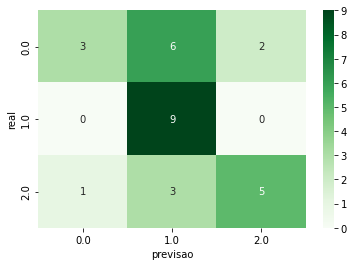

In [167]:
#confusion Matrix

df=pd.DataFrame(df,columns=['real','previsao' ])

cf_matrix=pd.crosstab(df['real'], df['previsao'], rownames=['real'] , colnames=['previsao'])

sns.heatmap(cf_matrix, annot=True, cmap='Greens')